# 8. Multivariate Time Series Forecasting with GRU

## Overview
- **Content:** This notebook builds a GRU model using PyTorch to perform time series forecasting of solar power generation and electricity demand. The experiment proceeds through the stages of data preparation, model definition, initial prediction, hyperparameter optimization using Optuna, and finally, post-optimization prediction.

### 8-1. Objective
The objective of this notebook is to build a GRU (Gated Recurrent Unit) model using PyTorch to predict target solar power generation and electricity demand from multivariate time series data, including external features identified in previous analyses.

We aim to capture the nonlinear relationships between multiple features that ARIMA and Prophet models could not fully account for, thereby improving prediction accuracy. Specifically, by integrating the impact of external features such as events and promotions on sales into the model, we strive for more realistic predictions.

### 8-2. Data Preparation

#### 8-2-1. Importing Libraries and Loading Data
Import the necessary libraries for building a predictive model, and load the pre-processed data.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from typing import List, Tuple, Callable, Dict, Optional, Any

import optuna

# Import common modules
from src.data_utils import load_timeseries_data
from src.evaluation_utils import evaluate_forecast
from src.plot_utils import plot_forecast_vs_actual

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams['font.family'] = 'Meiryo'

# Style and warning settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams['font.family'] = 'Meiryo'
warnings.filterwarnings('ignore')

# Device settings ('cuda' if GPU is available, otherwise 'cpu')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
# Load data
BASE_DIR = Path().resolve()
DATA_DIR = BASE_DIR.parent / "data"
target_file = DATA_DIR / "df_shifted.csv"

df = load_timeseries_data(target_file)

print("Data shape:", df.shape)
print("Data period:", df.index.min(), "to", df.index.max())
df.head()

Data shape: (39360, 16)
Data period: 2023-01-01 00:00:00 to 2025-03-30 23:30:00


,is_holiday,sin_hour,cos_hour,sin_weekday,cos_weekday,pressure_local,precipitation,temperature,dew_point,vapor_pressure,humidity,wind_speed,sunshine_duration,solar_radiation,solar_shifted,demand_shifted
datetime,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,1,0.000000,1.000000,-0.781831,0.62349,1018.20,0.0,3.80,-0.60,5.9,73.0,1.80,0.0,0.0,0.0,26500.0
2023-01-01 00:30:00,1,0.000000,1.000000,-0.781831,0.62349,1018.05,0.0,3.65,-0.55,5.9,74.0,1.40,0.0,0.0,0.0,25590.0
2023-01-01 01:00:00,1,0.258819,0.965926,-0.781831,0.62349,1017.90,0.0,3.50,-0.50,5.9,75.0,1.00,0.0,0.0,0.0,24850.0
2023-01-01 01:30:00,1,0.258819,0.965926,-0.781831,0.62349,1018.00,0.0,3.35,-0.75,5.8,74.5,1.15,0.0,0.0,0.0,24460.0
2023-01-01 02:00:00,1,0.500000,0.866025,-0.781831,0.62349,1018.10,0.0,3.20,-1.00,5.7,74.0,1.30,0.0,0.0,0.0,24430.0


#### 8-2-2. Defining GRU Model and Dataset Functions

In [3]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_len, dropout_rate):
        super(GRUModel, self).__init__()
        self.output_len = output_len
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=(dropout_rate if num_layers > 1 else 0)
        )
        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, output_len)
        )

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        output, h_n = self.gru(x)
        # h_n shape: (num_layers, batch_size, hidden_size)
        final_hidden = h_n[-1]
        # final_hidden shape: (batch_size, hidden_size)
        pred = self.fc(final_hidden)
        # pred shape: (batch_size, output_len)
        return pred

def make_dataset(X, y, time_steps, y_length):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - y_length + 1):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps:i + time_steps + y_length])
    return np.array(Xs), np.array(ys)

#### 8-2-3. Definition of Common Parameters and Variables

In [4]:
# Sliding window settings
TRAIN_LENGTH = 2880  # 60 days
TEST_LENGTH = 48     # 1 day
SLIDE_COUNT = 30     # 30 days
STRIDE = 48          # 1 day

# GRU model and training settings
SEQUENCE_LENGTH = 48  # Use 1 day's data as one sequence
N_EPOCHS = 15
OPTUNA_N_TRIALS = 20 # Number of Optuna trials

# Definition of target and explanatory variables
TARGET_SOLAR = 'solar_shifted'
FEATURES_SOLAR = [
    'solar_radiation', 'cos_hour', 'sunshine_duration', 'temperature','sin_hour', 
    'pressure_local', 'precipitation', 'humidity', 'wind_speed', 'sin_weekday'
]

TARGET_DEMAND = 'demand_shifted'
FEATURES_DEMAND = [
    'vapor_pressure', 'temperature', 'humidity', 'sin_hour', 'cos_hour','solar_radiation', 
    'sin_weekday', 'cos_weekday', 'is_holiday', 'pressure_local', 'precipitation'
]

### 8-3. Definition of Prediction Execution Process
- This analysis employs the Sliding Window method for time series prediction. With this approach, training and prediction are iteratively performed in window units.

- To manage this complex process, we define a `run_prediction` function that encapsulates a series of operations: data splitting, scaling, sequence creation, model training, prediction, and evaluation. Specifically, the design strictly prevents information leakage from the test data by performing scaling solely with the training data within each window.

In [5]:
def run_prediction(
    target_col,
    feature_cols,
    mase_period,
    model_params,
    run_title,
    y_shift = None  # Used to revert the shift/alignment if applied; defaults to None
):
    """
    Run sliding-window forecasting using a GRU model (multi-step).
    Supports optional post-alignment by shifting prediction DataFrame.

    Parameters
    ----------
    target_col : str
        Column name of the target variable.
    feature_cols : list of str
        Names of explanatory feature columns.
    mase_period : int
        Seasonal period for MASE evaluation.
    model_params : dict
        GRU hyperparameters. Expected keys:
            ['hidden_size', 'num_layers', 'dropout_rate',
             'batch_size', 'lr'].
    run_title : str
        Title printed for logging and used in plots.
    y_shift : int or None, default None
        If provided, the concatenated result DataFrame is shifted by
        this amount (positive values shift forward). `dropna()` is
        applied afterward.

    Returns
    -------
    results_df : pd.DataFrame
        DataFrame containing the concatenated true and predicted values
        across all sliding windows. Index corresponds to original timestamps.
    metrics : dict
        Evaluation metrics including MAE, RMSE, MASE, etc.

    Notes
    -------
    - Requires global variables: df, TRAIN_LENGTH, TEST_LENGTH,
      SLIDE_COUNT, STRIDE, SEQUENCE_LENGTH, N_EPOCHS, DEVICE.
    - A fresh GRU model is trained for each sliding window.
    - Scaling uses training data only (MinMaxScaler).
    - Multi-step forecasting uses the last SEQUENCE_LENGTH samples.
    - If y_shift is provided, index alignment changes after shift/dropna.
    """
    print(f"--- {run_title} ---")
    
    all_preds = []
    y_train_for_mase = df[target_col].iloc[:TRAIN_LENGTH].values
    
    # Also add the target variable to the features
    all_feature_cols = feature_cols + [target_col]

    for i in tqdm(range(SLIDE_COUNT), desc=f"Sliding Window for {target_col}"):
        # 1. Data Window Splitting
        train_start = i * STRIDE
        train_end = train_start + TRAIN_LENGTH
        test_end = train_end + TEST_LENGTH
        if test_end > len(df):
            break

        train_df = df.iloc[train_start:train_end]
        test_df = df.iloc[train_end:test_end]

        # 2. Scaling
        X_scaler = MinMaxScaler()
        y_scaler = MinMaxScaler()

        X_train_scaled = X_scaler.fit_transform(train_df[all_feature_cols])
        y_train_scaled = y_scaler.fit_transform(train_df[[target_col]]).flatten()
        
        # 3. Create Sequence Data
        X_train_seq, y_train_seq = make_dataset(
            X_train_scaled, y_train_scaled, SEQUENCE_LENGTH, TEST_LENGTH
        )
        
        if X_train_seq.shape[0] == 0:
            print(f"Window {i+1}: Not enough data to create sequences. Skipping.")
            continue

        X_train_tensor = torch.FloatTensor(X_train_seq).to(DEVICE)
        y_train_tensor = torch.FloatTensor(y_train_seq).to(DEVICE)
        
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=model_params['batch_size'], shuffle=True)

        # 4. Model Training
        model = GRUModel(
            input_size=len(all_feature_cols),
            hidden_size=model_params['hidden_size'],
            num_layers=model_params['num_layers'],
            output_len=TEST_LENGTH,
            dropout_rate=model_params['dropout_rate']
        ).to(DEVICE)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=model_params['lr'])
        criterion = nn.MSELoss()

        model.train()
        for epoch in range(N_EPOCHS):
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                loss.backward()
                optimizer.step()

        # 5. Prediction
        model.eval()
        with torch.no_grad():
            # Create input sequence for prediction (last SEQUENCE_LENGTH samples of training data)
            input_sequence_scaled = X_train_scaled[-SEQUENCE_LENGTH:]
            input_tensor = torch.FloatTensor(input_sequence_scaled).unsqueeze(0).to(DEVICE)
            
            preds_scaled = model(input_tensor).cpu().numpy().flatten()

        # 6. Revert Scaling
        preds = y_scaler.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()
        
        df_i = pd.DataFrame({"true": test_df[target_col].values, "pred": preds}, index=test_df.index)
        all_preds.append(df_i)

    # Aggregate and Evaluate Results
    if not all_preds:
        print("No predictions were made.")
        return

    results_df = pd.concat(all_preds)
    if y_shift is not None:
        results_df = results_df.shift(y_shift).dropna()
    metrics = evaluate_forecast(results_df['true'], results_df['pred'], y_train_for_mase, m=mase_period)
    
    print(f"Evaluation Metrics ({target_col}):")
    print(pd.DataFrame([metrics]))
    
    plot_forecast_vs_actual(results_df, f'{run_title}: {target_col}', days_to_show=10)

    return results_df, metrics

### 8-4. Prediction of Solar Power Generation (`solar_gen_mw`)
First, we will build a prediction model for the target variable `solar_gen_mw` (solar power generation).

#### 8-4-1. Prediction with Initial Parameters
First, we train a baseline model using empirically set initial hyperparameters and evaluate its prediction accuracy.

--- Initial Prediction ---


Sliding Window for solar_shifted:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluation Metrics (solar_shifted):
           MAE         RMSE      MASE
0  2104.309513  2719.448317  2.860025


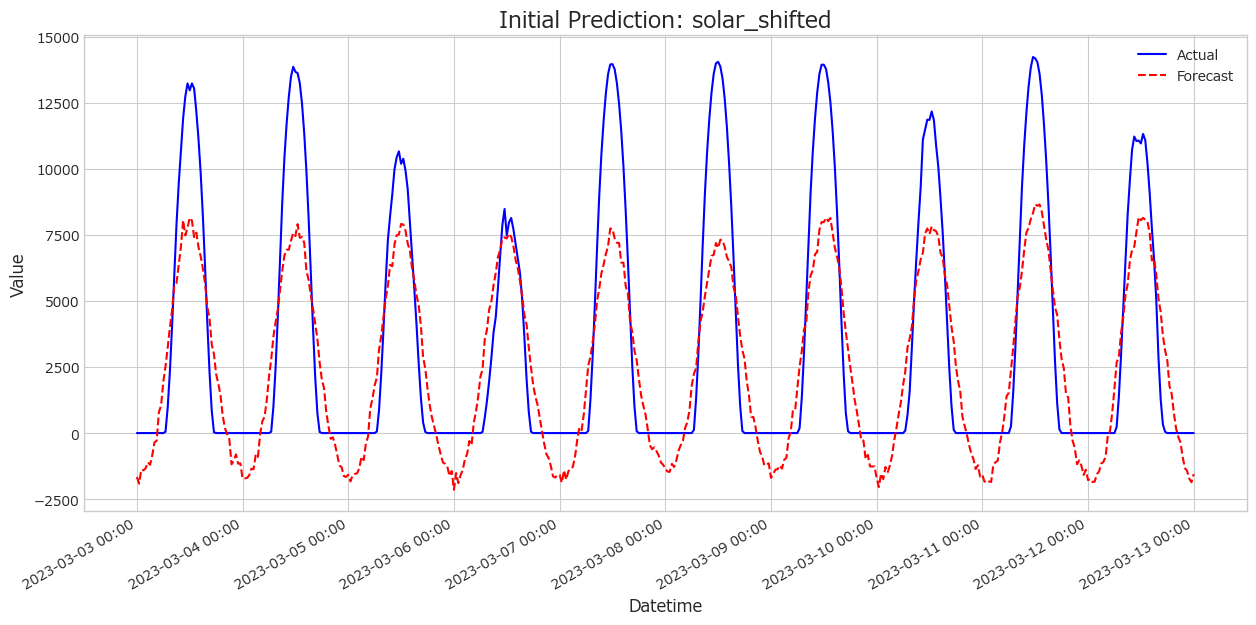

In [6]:
# Initial Hyperparameters
initial_solar_params = {
    'hidden_size': 256,
    'num_layers': 2,
    'lr': 1e-4,
    'batch_size': 256,
    'dropout_rate': 0.3,
}

solar_initial_df, solar_initial_metrics = run_prediction(
    target_col=TARGET_SOLAR,
    feature_cols=FEATURES_SOLAR,
    mase_period=48,
    model_params=initial_solar_params,
    run_title="Initial Prediction",
    y_shift=48
)

Evaluation Metrics (solar_shifted):
```
          MAE         RMSE      MASE
0  2037.39874  2704.551639  2.769084
```

#### 8-4-2. Hyperparameter Optimization with Optuna
To improve the accuracy of initial predictions, hyperparameter optimization will be performed using Optuna. The objective function will be RMSE (Root Mean Squared Error) for the validation data, and a combination of parameters that minimizes this value will be searched for.

The main hyperparameters to be explored are as follows:
*   `hidden_size`: Dimension of the GRU layer's hidden state
*   `num_layers`: Number of GRU layers
*   `lr`: Learning rate
*   `batch_size`: Batch size
*   `dropout_rate`: Dropout rate
*   `sequence_length`: Sequence length

In [7]:


def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def objective_solar(trial):
    set_seed(42)
    # Tuning uses only data from the first TRAIN_LENGTH (60 days)
    tuning_df = df.iloc[:TRAIN_LENGTH].copy()
    
    # Hyperparameter suggestions
    params = {
        'hidden_size': trial.suggest_categorical('hidden_size', [64, 128, 256]),
        'num_layers': trial.suggest_int('num_layers', 1, 3, 5),
        'lr': trial.suggest_float('lr', 1e-5, 1e-3, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256]),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
        'sequence_length': trial.suggest_categorical('sequence_length', [48, 48*2, 48*7]),
    }
    
    all_feature_cols = FEATURES_SOLAR + [TARGET_SOLAR]
    
    # Sliding window settings
    train_len = 48 * 48
    test_len = 48
    slide_count = 12
    stride = 48
    
    window_rmses = []

    for i in range(slide_count):
        train_start = i * stride
        train_end = train_start + train_len
        test_end = train_end + test_len
        
        train_window_df = tuning_df.iloc[train_start:train_end]
        test_window_df = tuning_df.iloc[train_end:test_end]

        # Scaling
        X_scaler = MinMaxScaler()
        y_scaler = MinMaxScaler()
        X_train_scaled = X_scaler.fit_transform(train_window_df[all_feature_cols])
        y_train_scaled = y_scaler.fit_transform(train_window_df[[TARGET_SOLAR]]).flatten()
        
        # Create sequence data
        X_train_seq, y_train_seq = make_dataset(X_train_scaled, y_train_scaled, params['sequence_length'], test_len)
        if X_train_seq.shape[0] == 0: continue

        X_train_tensor = torch.FloatTensor(X_train_seq).to(DEVICE)
        y_train_tensor = torch.FloatTensor(y_train_seq).to(DEVICE)
        train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=params['batch_size'], shuffle=True)

        # Model training
        model = GRUModel(
            input_size=len(all_feature_cols), hidden_size=params['hidden_size'],
            num_layers=params['num_layers'], output_len=test_len,
            dropout_rate=params['dropout_rate']
        ).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
        criterion = nn.MSELoss()

        model.train()
        for epoch in range(N_EPOCHS):
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                loss.backward()
                optimizer.step()

        # Evaluation
        model.eval()
        with torch.no_grad():
            input_sequence_scaled = X_train_scaled[-params['sequence_length']:]
            input_tensor = torch.FloatTensor(input_sequence_scaled).unsqueeze(0).to(DEVICE)
            preds_scaled = model(input_tensor).cpu().numpy().flatten()

        preds = y_scaler.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()
        rmse = np.sqrt(mean_squared_error(test_window_df[TARGET_SOLAR].values, preds))
        window_rmses.append(rmse)

    if not window_rmses:
        return float('inf') # or optuna.exceptions.TrialPruned()
        
    return np.mean(window_rmses)

# Run Optuna
set_seed(42)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_solar = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_solar.optimize(objective_solar, n_trials=OPTUNA_N_TRIALS, show_progress_bar=True)

print("Best trial for Solar:")
best_params_solar = study_solar.best_params
print(f"  Value: {study_solar.best_value}")
print(f"  Params: {best_params_solar}")

  0%|          | 0/20 [00:00<?, ?it/s]

Best trial for Solar:
  Value: 1630.5934575834146
  Params: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.000189370370161544, 'batch_size': 64, 'dropout_rate': 0.1488007070906256, 'sequence_length': 96}


#### 8-4-3. Final Prediction Using Optimized Parameters
Using the optimal hyperparameters obtained by Optuna, we will retrain the model and perform predictions again to confirm the performance improvement from the baseline model.

--- Post-optimization prediction ---


Sliding Window for solar_shifted:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluation Metrics (solar_shifted):
           MAE         RMSE    MASE
0  1340.272051  2316.524625  1.8216


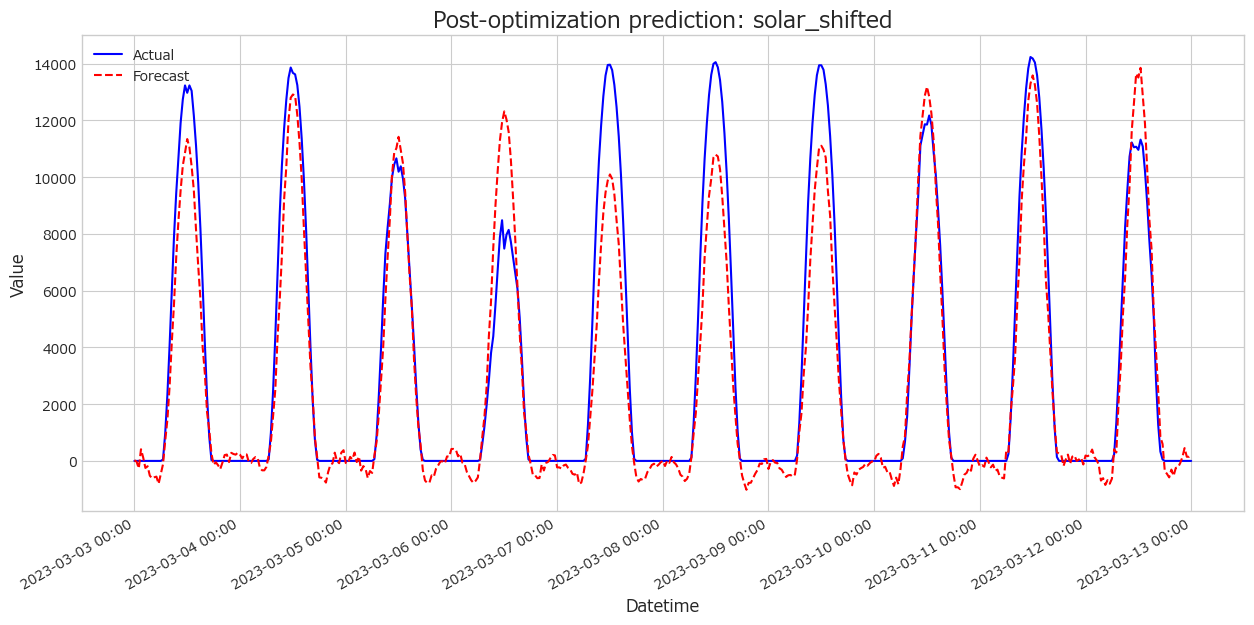

In [8]:
SEQUENCE_LENGTH = best_params_solar['sequence_length']
solar_tuned_df, solar_tuned_metrics = run_prediction(
    target_col=TARGET_SOLAR,
    feature_cols=FEATURES_SOLAR,
    mase_period=48,
    model_params=best_params_solar,
    run_title="Post-optimization prediction",
    y_shift=48
)

### 8-5. Forecasting Electricity Demand (`e_demand_mw`)
Next, we will build a prediction model for the target variable `e_demand_mw` (electricity demand). The analysis will proceed using a process similar to that for solar power generation.

#### 8-5-1. Prediction with Initial Parameters
In electricity demand forecasting, we first construct a baseline model using initial hyperparameters and evaluate it.

--- Initial Prediction ---


Sliding Window for demand_shifted:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluation Metrics (demand_shifted):
           MAE         RMSE     MASE
0  2905.577226  3521.859078  0.92009


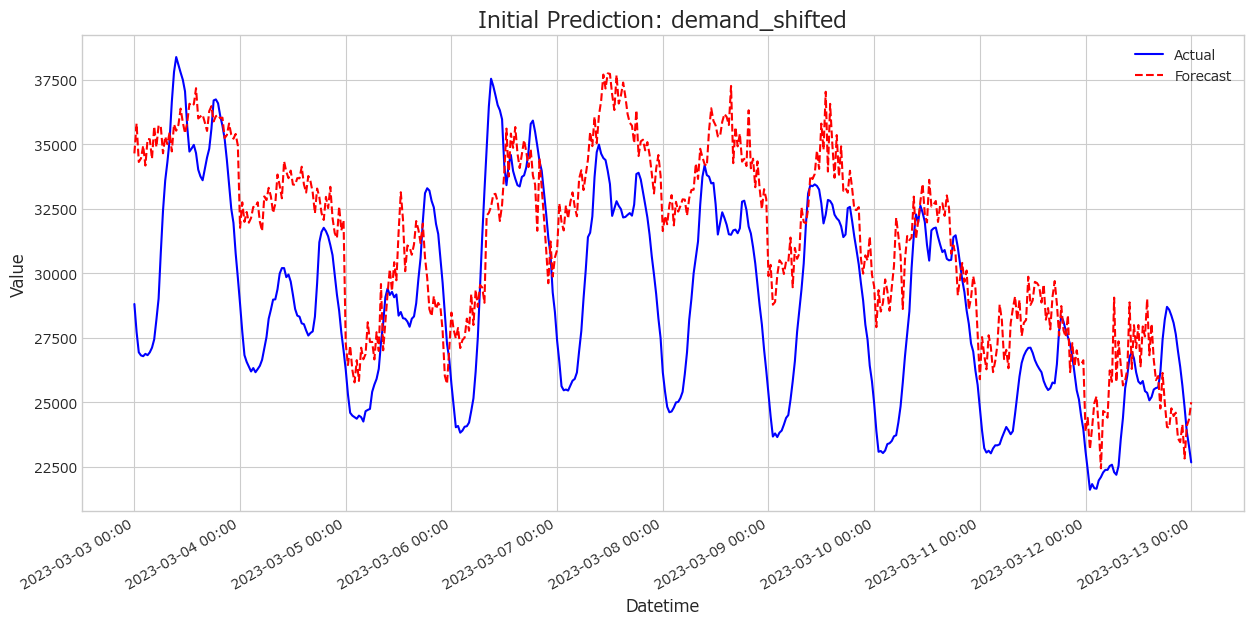

In [9]:
SEQUENCE_LENGTH = 336
# Initial hyperparameters
initial_demand_params = {
    'hidden_size': 256,
    'num_layers': 3,
    'lr': 1e-4,
    'batch_size': 256,
    'dropout_rate': 0.3,
}

demand_initial_df, demand_initial_metrics = run_prediction(
    target_col=TARGET_DEMAND,
    feature_cols=FEATURES_DEMAND,
    mase_period=336,
    model_params=initial_demand_params,
    run_title="Initial Prediction",
    y_shift=48
)

#### 8-5-2. Hyperparameter Optimization using Optuna
Similar to the solar power generation amount, we will perform hyperparameter optimization for the power demand prediction model using Optuna.

In [10]:
def objective_demand(trial):
    set_seed(42)
    tuning_df = df.iloc[:TRAIN_LENGTH].copy()
    
    params = {
        'hidden_size': trial.suggest_categorical('hidden_size', [64, 128, 256]),
        'num_layers': trial.suggest_int('num_layers', 1, 3, 5),
        'lr': trial.suggest_float('lr', 1e-5, 1e-3, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256]),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
        'sequence_length': trial.suggest_categorical('sequence_length', [48, 48*2, 48*7]),
    }
    
    all_feature_cols = FEATURES_DEMAND + [TARGET_DEMAND]
    
    train_len, test_len, slide_count, stride = 48 * 48, 48, 12, 48
    window_rmses = []

    for i in range(slide_count):
        train_start, train_end, test_end = i * stride, i * stride + train_len, i * stride + train_len + test_len
        train_window_df, test_window_df = tuning_df.iloc[train_start:train_end], tuning_df.iloc[train_end:test_end]

        X_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()
        X_train_scaled = X_scaler.fit_transform(train_window_df[all_feature_cols])
        y_train_scaled = y_scaler.fit_transform(train_window_df[[TARGET_DEMAND]]).flatten()
        
        X_train_seq, y_train_seq = make_dataset(X_train_scaled, y_train_scaled, params['sequence_length'], test_len)
        if X_train_seq.shape[0] == 0: continue

        train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train_seq).to(DEVICE), torch.FloatTensor(y_train_seq).to(DEVICE)), batch_size=params['batch_size'], shuffle=True)

        model = GRUModel(len(all_feature_cols), params['hidden_size'], params['num_layers'], test_len, params['dropout_rate']).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
        criterion = nn.MSELoss()

        model.train()
        for epoch in range(N_EPOCHS):
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                loss = criterion(model(X_batch), y_batch)
                loss.backward()
                optimizer.step()

        model.eval()
        with torch.no_grad():
            input_sequence_scaled = X_train_scaled[-params['sequence_length']:]
            preds_scaled = model(torch.FloatTensor(input_sequence_scaled).unsqueeze(0).to(DEVICE)).cpu().numpy().flatten()

        preds = y_scaler.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()
        rmse = np.sqrt(mean_squared_error(test_window_df[TARGET_DEMAND].values, preds))
        window_rmses.append(rmse)

    if not window_rmses: return float('inf')
    return np.mean(window_rmses)

optuna.logging.set_verbosity(optuna.logging.WARNING)
set_seed(42)
study_demand = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_demand.optimize(objective_demand, n_trials=OPTUNA_N_TRIALS, show_progress_bar=True)

print("Best trial for Demand:")
best_params_demand = study_demand.best_params
print(f"  Value: {study_demand.best_value}")
print(f"  Params: {best_params_demand}")

  0%|          | 0/20 [00:00<?, ?it/s]

Best trial for Demand:
  Value: 2655.576569093536
  Params: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.0005816123061832371, 'batch_size': 64, 'dropout_rate': 0.23560565778823855, 'sequence_length': 96}


#### 8-5-3. Final Prediction using Optimized Parameters
Train the final model using the optimized hyperparameter set and evaluate its prediction accuracy.

--- Optimized Prediction ---


Sliding Window for demand_shifted:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluation Metrics (demand_shifted):
          MAE         RMSE      MASE
0  2119.56211  2908.045839  0.671188


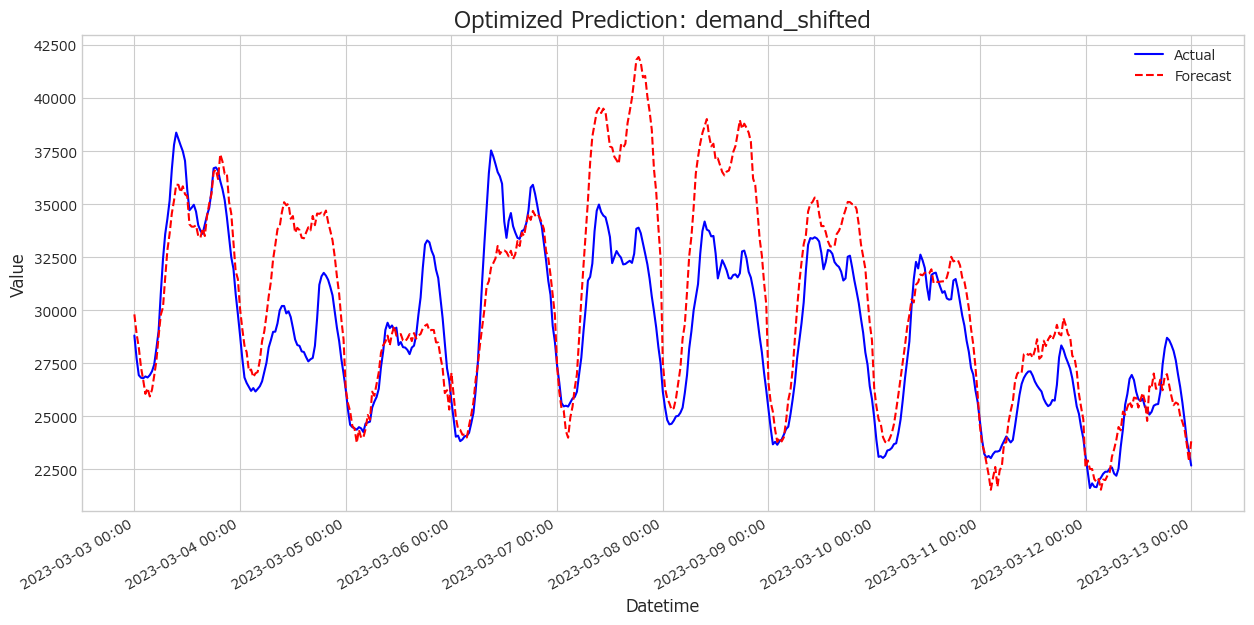

In [11]:
SEQUENCE_LENGTH = best_params_demand['sequence_length']
demand_tuned_df, demand_tuned_metrics = run_prediction(
    target_col=TARGET_DEMAND,
    feature_cols=FEATURES_DEMAND,
    mase_period=336,
    model_params=best_params_demand,
    run_title="Optimized Prediction",
    y_shift=48
)

In [12]:
# Merge evaluation tables
comparison_df = pd.DataFrame({
    'Solar_Initial': solar_initial_metrics,
    'Solar_Tuned': solar_tuned_metrics,
    'Demand_Initial': demand_initial_metrics,
    'Demand_Tuned': demand_tuned_metrics
})
print(comparison_df)

      Solar_Initial  Solar_Tuned  Demand_Initial  Demand_Tuned
MAE     2104.309513  1340.272051     2905.577226   2119.562110
RMSE    2719.448317  2316.524625     3521.859078   2908.045839
MASE       2.860025     1.821600        0.920090      0.671188


In [13]:
# Saving results
# Assuming pred_df has 'true', 'pred' columns and a datetime index

# solar_gen_mw
solar_tuned_df.to_pickle('../results/preds/solar_GRU.pkl')
print("Saved: ")

# e_demand_mw
demand_tuned_df.to_pickle('../results/preds/demand_GRU.pkl')
print("Saved: ")

Saved: 
Saved: 


### 8-6. Conclusion and Discussion
In this analysis, a GRU model was constructed using PyTorch, and multivariate time series forecasting of solar power generation and electricity demand was attempted. Through hyperparameter optimization with Optuna, a certain improvement in accuracy from the initial model (MASE for solar power generation forecast: `2.90` → `1.83`) was confirmed.

However, relative to the computational load, the predictive accuracy of the GRU model was insufficient, especially for consumption. The factors considered are as follows:
*   **Representation of Physical Constraints**: Solar power generation has the physical constraint of becoming zero at night, but the predicted values of the GRU model oscillated during nighttime hours and exhibited unstable behavior, such as taking negative values. This suggests that the model failed to capture the physical background of the data.
*   **Tracking Spike-like Fluctuations**: In the prediction of electricity demand, while the overall trend was captured, the sharp increase in demand (spikes) on specific days could not be accurately predicted, contributing to significant errors.
*   **Model Complexity and Efficiency**: While GRU is a powerful model for capturing time series dependencies, its complexity did not necessarily translate to high predictive accuracy in this task. Hyperparameter tuning also required many trials. However, unlike LightGBM, improvements were observed with tuning.

On the other hand, the process of this analysis contains practical insights more significant than the numerical results. In particular, **strict measures to prevent data leakage in the Sliding Window method** were carefully implemented. Within each window's loop, training and test data were clearly separated, and the process of fitting the scaler solely to the training data was thoroughly enforced. This is fundamental for fairly evaluating the generalization performance of time series models, and an indispensable process for demonstrating technical reliability as an analyst.

Although the performance of the GRU model in this instance did not meet expectations, the experience gained from this rigorous process design, along with insights into the characteristics of deep learning models (their strengths and weaknesses), will undoubtedly be valuable in future, more advanced analysis projects.

**Future Development**
*   **Implementing Model Constraints**: For solar power generation forecasting, consider improvements such as applying an activation function (e.g., ReLU) to the final layer to ensure non-negative output, or clipping negative values to zero in post-processing.
*   **Exploring Hybrid Models**: Construct a hybrid model that combines trend and seasonality components captured by ARIMA or Prophet with residuals (nonlinear components) captured by GRU.
*   **Optuna Stabilization**: To reduce the variability in optimization results, consider measures such as increasing `n_trials` or fixing the seed of `TPESampler`.